In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from Time_Delay_Gaussian import *
from scipy.integrate import odeint

# Lorenz 1963

In [2]:
par = np.array([10,28,8/3])

x0 = np.array([1,0.2,19])
t = np.arange(0,500,0.002)

#lorenz63 model
def lorenz63(n, t):
    #gNa,ENa,gK,EK,gL,EL,Vm1,dVm,taum0,taum1,Vh0,dVh,tauh0,tauh1,Vn1,dVn,taun0,taun1,F = p
    x,y,z = n
    dXdt = [par[0]*(-x + y),
        x*(par[1] - z) - y,
        -par[2]*z + x*y]
    return dXdt
L63 = odeint(lorenz63,x0,t).T

In [3]:
tau = 13
D = 11
length = 10000
Xdata = L63[0]
TT = 0.002
NoCenters = 500

start_time = time.time()
DDF = TDEGauss()
#Center = DDF.KmeanCenter(Xdata,NoCenters,D,length,tau)
#print("--- %s seconds ---" % (time.time() - start_time))
#np.save('Centers_FullL63_train10k_500_D3_tau'+str(tau)+'.npy',Center)
Center = np.load('Center_'+str(D)+'_'+str(tau)+'.npy')

In [4]:
Pdata = Xdata
PreLength = 10000

beta = 6.680359280320344e-08
R=0.005041444147767352

start_time = time.time()
F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D,tau)
print("--- %s seconds ---" % (time.time() - start_time))
Pred = DDF.PredictIntoTheFuture(F,PreLength,Pdata[length-2:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.3143630027770996 seconds ---
--- 0.6017038822174072 seconds ---


In [5]:
Lyap_large = 0.9056
maxx = PreLength
X = np.arange(0,maxx*0.002*Lyap_large,0.002*Lyap_large)

<function matplotlib.pyplot.show(close=None, block=None)>

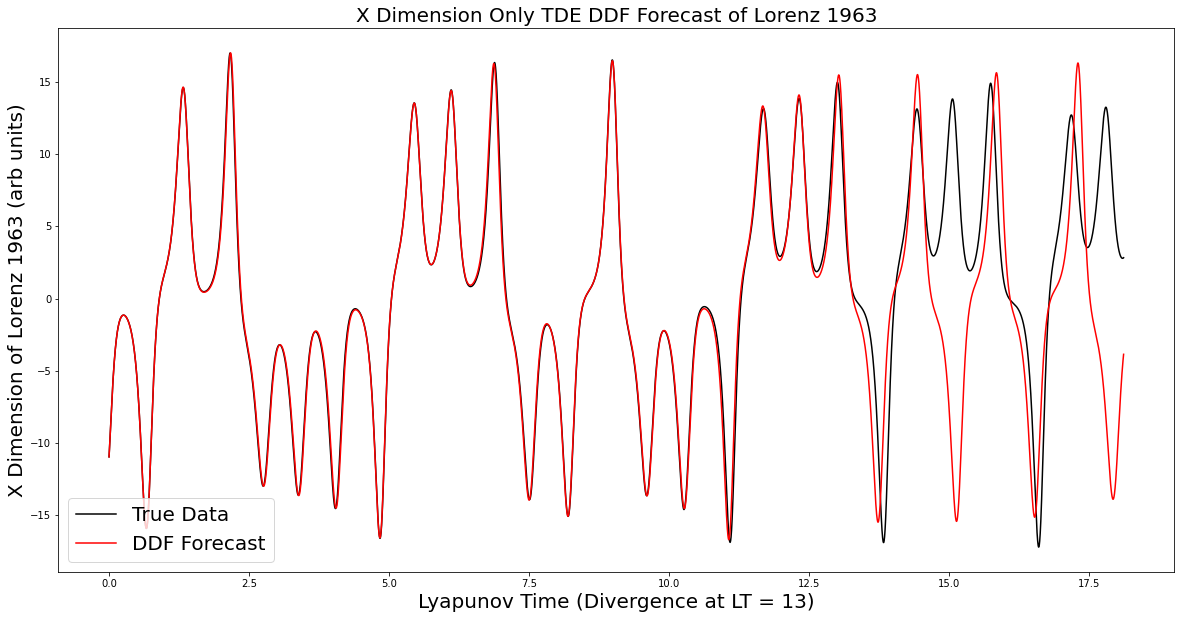

In [6]:
plt.figure(figsize=(20,10))
plt.plot(X,Xdata[length+(D-1)*tau-1:(D-1)*tau-1+length+PreLength],label = 'True Data', color = 'black')
plt.plot(X,Pred[(D-1)*tau+1:],label = 'DDF Forecast', color = 'r')
plt.xlabel('Lyapunov Time (Divergence at LT = 13)',fontsize=20)
plt.ylabel('X Dimension of Lorenz 1963 (arb units)',fontsize=20)
plt.legend(fontsize=20)
plt.title('X Dimension Only TDE DDF Forecast of Lorenz 1963',fontsize=20)
plt.savefig('TDE X only L63 Graph')
plt.show

In [7]:
DD = [3,4,5,6]
TAU = [25,27,30,32,35,37,40,42,45]

In [15]:
for d in range(4):
    for t in range(len(TAU)):
        tau = TAU[t]
        D = DD[d]
        length = 10000
        Xdata = L63[0]
        NoCenters = 500

        start_time = time.time()
        DDF = TDEGauss()
        Center = DDF.KmeanCenter(Xdata,NoCenters,D,length,tau)
        #print("--- %s seconds ---" % (time.time() - start_time))
        np.save('Centers_FullL63_train10k_500_D'+str(D)+'_tau'+str(tau)+'.npy',Center)
        #Center = np.load('Centers_FullL63_train10k_500_D3_tau'+str(tau)+'.npy')
        
        for i in range(10):
            for j in range(10):
                Pdata = Xdata
                PreLength = 10000

                #beta = 1e-1
                #R=1e-2
                beta = 10**(-8+i)
                R = 10**(-8+j)

                start_time = time.time()
                F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D,tau)
                print("--- %s seconds ---" % (time.time() - start_time))
                Pred = DDF.PredictIntoTheFuture(F,PreLength,Pdata[length-1-(D-1)*tau:])
                print("--- %s seconds ---" % (time.time() - start_time))
                
                
                Cost = Cost_Gainer(Pred[tau*(D-1)+1:tau*(D-1)+PreLength+1],Xdata[length:length + PreLength],PreLength,sigma,epsilon,1)
                
                plt.figure(figsize=(20,10))
                plt.plot(X,Xdata[length:length + PreLength],label = 'True Voltage', color = 'black')
                plt.plot(X,Pred[tau*(D-1)+1:tau*(D-1)+PreLength+1],label = 'Prediction', color = 'r')
                plt.xlabel('time (ms)',fontsize=20)
                plt.ylabel('Voltage',fontsize=20)
                plt.legend()
                plt.title('d is '+str(d)+' tau is '+str(t)+' i is '+str(i)+' j is '+str(j),fontsize=20)
                plt.savefig(str(Cost))
                #plt.show

In [8]:
sigma = np.std(L63,axis=1)[0]
epsilon = 0.5
def Cost_Gainer(NewResult,TrueData,PredictionLength,sigma,epsilon,D):
        #Both true and estimated data must be in time by dimension format
        #Sigma is a D dimensional vector
        #Epsilon should be about 0.5
        if np.isnan(NewResult).any():
            return 0
        
        
        for i in range(PredictionLength):
            Error = ((NewResult[i]-TrueData[i])/sigma)**2
            Error = (np.sum(Error)/D)**0.5
            if Error > epsilon:
                return i
        return PredictionLength